### Imports

In [1]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.model_selection import train_test_split

### Read the dataset

In [2]:
df = pd.read_csv("../sample_data/50000.csv",nrows=2000)

In [3]:
# split the dataset
# train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

### Calculate Association Rules

In [4]:
columns = df.columns
# Convert the dataframe into a list of lists
records = df.values.tolist()

new_records = []
for record in records:
    # new_records.append(list(filter(lambda a: a != 0, record)))
    new_records.append(record)

records = new_records

# Convert all values to string
records = [[str(item) for item in record] for record in records]
# Initialize TransactionEncoder
te = TransactionEncoder()

# Transform the data into an array
encoded_data = te.fit(records).transform(records)

# Convert the array into a dataframe
df_encoded = pd.DataFrame(encoded_data, columns=te.columns_)

# Apply Apriori algorithm
frequent_itemsets = apriori(df_encoded, min_support=0.2, use_colnames=True)

# Generate Association Rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)


In [5]:
sorted_by_support = frequent_itemsets.sort_values(by="support", ascending=False)
print(sorted_by_support.head(10).to_string())

    support      itemsets
0    1.0000           (0)
1    0.9880           (1)
6    0.9880        (1, 0)
8    0.5450     (31.0, 0)
3    0.5450        (31.0)
16   0.5355  (1, 0, 31.0)
12   0.5355     (31.0, 1)
9    0.4350     (0, 44.0)
4    0.4350        (44.0)
13   0.4330     (1, 44.0)


In [6]:
sorted_by_confidence = rules.sort_values(by="confidence", ascending=False)
print(sorted_by_confidence.head(10).to_string(index=False))

antecedents consequents  antecedent support  consequent support  support  confidence     lift  leverage  conviction  zhangs_metric
        (1)         (0)              0.9880               1.000   0.9880         1.0 1.000000   0.00000         inf        0.00000
       (84)         (1)              0.3300               0.988   0.3300         1.0 1.012146   0.00396         inf        0.01791
    (84, 0)         (1)              0.3300               0.988   0.3300         1.0 1.012146   0.00396         inf        0.01791
    (1, 84)         (0)              0.3300               1.000   0.3300         1.0 1.000000   0.00000         inf        0.00000
  (1, 44.0)         (0)              0.4330               1.000   0.4330         1.0 1.000000   0.00000         inf        0.00000
  (1, 31.0)         (0)              0.5355               1.000   0.5355         1.0 1.000000   0.00000         inf        0.00000
     (1, 2)         (0)              0.3185               1.000   0.3185         1.

In [7]:
sorted_by_lift = rules.sort_values(by="lift", ascending=False)
print(sorted_by_lift.head(10).to_string(index=False))

antecedents consequents  antecedent support  consequent support  support  confidence     lift  leverage  conviction  zhangs_metric
       (84)      (1, 0)              0.3300              0.9880   0.3300    1.000000 1.012146   0.00396         inf       0.017910
    (84, 0)         (1)              0.3300              0.9880   0.3300    1.000000 1.012146   0.00396         inf       0.017910
       (84)         (1)              0.3300              0.9880   0.3300    1.000000 1.012146   0.00396         inf       0.017910
     (44.0)      (1, 0)              0.4350              0.9880   0.4330    0.995402 1.007492   0.00322        2.61       0.013162
  (0, 44.0)         (1)              0.4350              0.9880   0.4330    0.995402 1.007492   0.00322        2.61       0.013162
     (44.0)         (1)              0.4350              0.9880   0.4330    0.995402 1.007492   0.00322        2.61       0.013162
     (1, 2)         (0)              0.3185              1.0000   0.3185    1.00000

In [8]:
sorted_by_leverage = rules.sort_values(by="leverage", ascending=False)
print(sorted_by_leverage.head(10).to_string(index=False))

antecedents consequents  antecedent support  consequent support  support  confidence     lift  leverage  conviction  zhangs_metric
       (84)      (1, 0)              0.3300              0.9880   0.3300    1.000000 1.012146   0.00396         inf       0.017910
    (84, 0)         (1)              0.3300              0.9880   0.3300    1.000000 1.012146   0.00396         inf       0.017910
       (84)         (1)              0.3300              0.9880   0.3300    1.000000 1.012146   0.00396         inf       0.017910
     (44.0)      (1, 0)              0.4350              0.9880   0.4330    0.995402 1.007492   0.00322        2.61       0.013162
  (0, 44.0)         (1)              0.4350              0.9880   0.4330    0.995402 1.007492   0.00322        2.61       0.013162
     (44.0)         (1)              0.4350              0.9880   0.4330    0.995402 1.007492   0.00322        2.61       0.013162
     (1, 2)         (0)              0.3185              1.0000   0.3185    1.00000

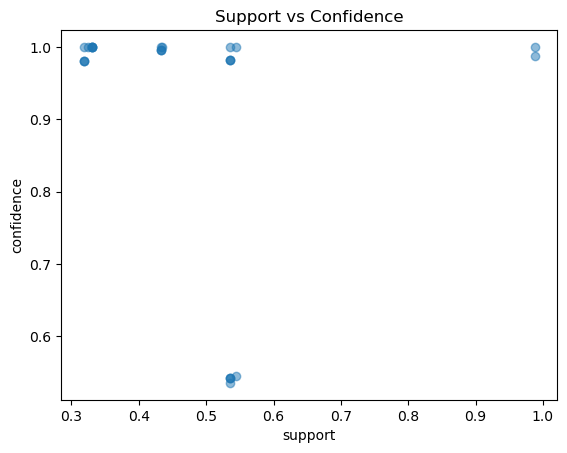

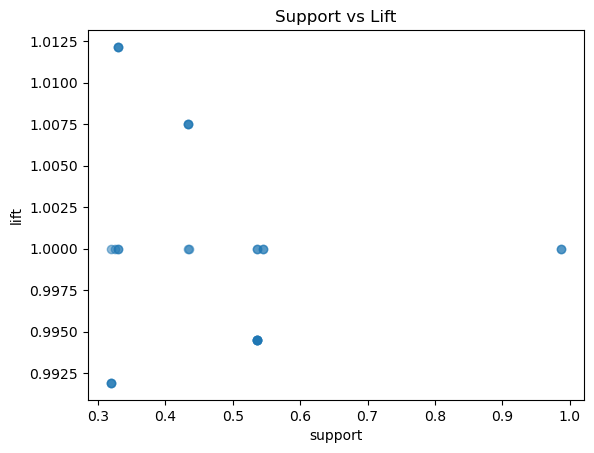

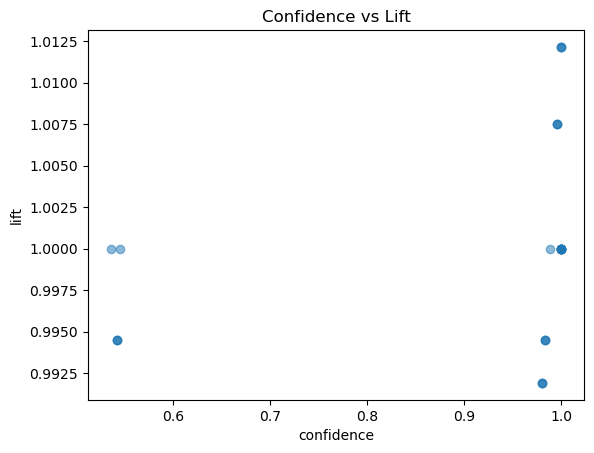

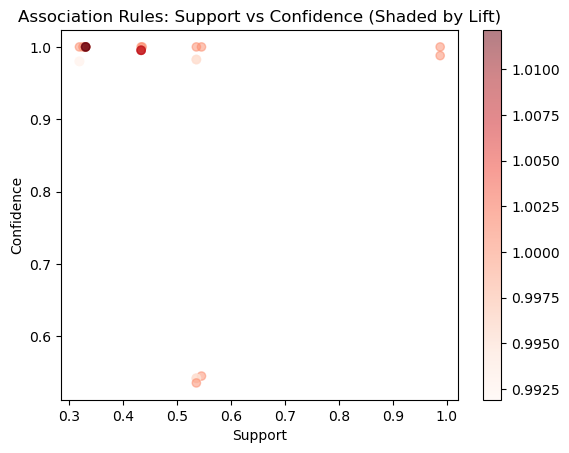

In [9]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot support vs. confidence
plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

# Plot support vs. lift
plt.scatter(rules['support'], rules['lift'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('lift')
plt.title('Support vs Lift')
plt.show()

# Plot confidence vs. lift
plt.scatter(rules['confidence'], rules['lift'], alpha=0.5)
plt.xlabel('confidence')
plt.ylabel('lift')
plt.title('Confidence vs Lift')
plt.show()

# Plot support vs. confidence with shading as lift
plt.scatter(rules['support'], rules['confidence'], c=rules['lift'], cmap='Reds', alpha=0.5)
plt.colorbar()
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association Rules: Support vs Confidence (Shaded by Lift)')
plt.show()
